<a href="https://colab.research.google.com/github/pappuyadav/Squat-Detection-Using-VGG16-and-LSTM/blob/master/detect_latest_keypoints_to_LSTM_5_9_2020_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 144429 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

In [2]:
!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 97kB/s 
     |████████████████████████████████| 491kB 54.5MB/s 
     |████████████████████████████████| 3.2MB 60.3MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc4
    Uninstalling tensorflow-2.2.0rc4:
      Successfully uninstalled tensorflow-2.2.0rc4


In [0]:
#Download example video file from youtube
!youtube-dl -f 'bestvideo[ext=mp4]' --output "andrew_jiang.%(ext)s" https://www.youtube.com/watch?v=m-o_i4C6bxs&feature=youtu.be

In [0]:
#Generate two directories. 
!mkdir keypoints
!mkdir frames


In [0]:
#Generating image frames for each video files in avi format. Here example video file name is "sq8.avi". 
#Upload your test video file (in avi format) in the home folder then replace 'output_sq4.mp4' with your video file
import cv2

vidcap = cv2.VideoCapture('/content/andrew_jiang_6200_1.mp4')
success,image = vidcap.read()

count = 0
while success:
  cv2.imwrite("/content/frames/andrew_jiang_6200_1_frame%d.jpg" % count, image)     # save frame as JPEG file
  success,image = vidcap.read()
  print ('Read a new frame: ', success)
  count += 1


In [0]:
# Use this section to create pose detect. Make sure to use right video files in .avi format  
!cd openpose && ./build/examples/openpose/openpose.bin --video ../andrew_jiang_6200_1.mp4 --write_json ./output/ --display 0  --write_video ../openpose_andrew_jiang_6200_1.avi
!ffmpeg -y -loglevel info -i /content/openpose_andrew_jiang_6200_1.avi /content/openpose_andrew_jiang_6200_1.mp4

In [0]:
#Please make two directories to put training image frames and test image frames
#First half of training image frames consist of non-squat and remaining half consists of squat frames
#701 training images frames are used.Keypoints corresponding to these are used for training and validation
#267 frames blong to squat and remaining 434 frames belong to no-squat
#Please use your keypoints corresponding to squat frames in /content/keypoints/train_squat and corresponding to no-squat in /content/keypoints/train_nosquat

!mkdir /content/keypoints/train_squat
!mkdir /content/keypoints/train_nosquat


In [0]:
%tensorflow_version 1.x
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import sequence
import os
import numpy as np
from keras.utils import np_utils
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,Flatten,GlobalAveragePooling2D,Input,LSTM,Embedding, TimeDistributed
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from scipy import ndimage
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
import cv2
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,f1_score


Name="Squat_Detection{}".format(int(time.time()))

tensorboard=TensorBoard(log_dir='logs/{}'.format(Name))

#Uisng 2D Keypoints generated from Openpose
# Loading 2D keypoints from JSON files
def read_josn(filepath):
  with open(filepath,'r')as f:
    data=json.load(f)
  return(data)

trainsquat_data=[]
for file in os.listdir('/content/keypoints/train_squat'):
  full_path='/content/keypoints/train_squat/'+ str(file)
  aa=read_josn(full_path)
  df=pd.DataFrame(aa)
  df=df['people'][0]['pose_keypoints_2d']
  trainsquat_data.append(df)
  #print(df)

train_nosquat_data=[]
for file in os.listdir('/content/keypoints/train_nosquat'):
  full_path='/content/keypoints/train_nosquat/'+ str(file)
  !rmdir /content/keypoints/train_nosquat/.ipynb_checkpoints
  aa=read_josn(full_path)
  df=pd.DataFrame(aa)
  df=df['people'][0]['pose_keypoints_2d']
  train_nosquat_data.append(df)
  #print(df)
squat_train=[]
no_squat_train=[]
squat_label=[]
no_squat_label=[]
labels=[]
#creating labels for squat and no_squat
for i in range(len(trainsquat_data)):
  squat_label.append(1)
#print(squat_label)

for i in range(len(train_nosquat_data)):
  no_squat_label.append(0)
#print(no_squat_label)

#combining the lables in one array
squat_label.extend(no_squat_label)
labels=np.array(squat_label)

#Creating training array
trainsquat_data.extend(train_nosquat_data)
squat_train=np.array(trainsquat_data)

#Defining number of classes
num_classes=2
num_samples=squat_train.shape[0]
labels=np.ones(num_samples,dtype='int64')
labels[0:267]=1  # Of the 701 frames,first 267 frames belong to squat i.e. class'1'
labels[267:701]=0  # remaining 434 frames belong to no_squat  i.e. class '0'
names=['squat','no_squat']
#convert class labels to one-hot encoding
Y = np_utils.to_categorical(labels, num_classes)
#Shuffle the training data set
xtrain,ytrain=shuffle(squat_train,Y,random_state=2)
#Splitting data for validation set
x_train, x_valid, y_train, y_valid = train_test_split(squat_train, labels, test_size=0.20, shuffle= True)

#Reshaping the data into 1 rows and 75 columns for 560 data values of training data and 141 data values of validation data
x_train=x_train.reshape(len(x_train),1,75)
x_valid=x_valid.reshape(len(x_valid),1,75)
#y_train=y_train.reshape(1,len(y_train))
#y_valid=y_valid.reshape(1,len(y_valid))

#The Dataset is ready to be fed into LSTM network
# We will now build and train LSTM architecture and then make predictions for squat and no_squat

X_train=x_train
Y_train=y_train
X_test=x_valid
Y_test=y_valid

# Truncating and padding input sequences of data after reshaping them 
timestep=1 
X_train = sequence.pad_sequences(X_train, maxlen=timestep)
X_test = sequence.pad_sequences(X_test, maxlen=timestep) 


#Building the LSTM architecture
size=50
embedding_vecor_length =8
lstm_model = Sequential()
#lstm_model.add(Embedding(size,embedding_vecor_length, input_length=timestep))
lstm_model.add(LSTM(128,input_shape=(X_train.shape[1:]),activation='relu',return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(32,activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(num_classes, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())
hist=lstm_model.fit(X_train, Y_train, epochs=1000, batch_size=75,verbose=1, validation_data=(X_test,Y_test), callbacks=[tensorboard])

#print('Training time: %s' % (t - time.time()))
(loss, accuracy) = lstm_model.evaluate(X_test,Y_test, batch_size=75, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

#Evaluating the LSTM model
train_acc = lstm_model.evaluate(X_train, Y_train, verbose=0)
test_acc = lstm_model.evaluate(X_test, Y_test, verbose=0)

temp=lstm_model.predict(X_test)
temp1=lstm_model.predict_classes(X_test)

# reduce to 1d array
yhat_probs = temp[:, 0]
yhat_classes = temp1[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes)
print('F1 score: %f' % f1)

# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(1000)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])



#Now saving the pretrained weights
# serialize model to JSON
model_json = lstm_model.to_json()
with open("trained_data_squats.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
lstm_model.save_weights("trained_data_squats.h5")
print("Saved trained_data to disk")



In [0]:
X_train.shape
X_test.shape

(560, 1, 75)

In [0]:
#Zipping header and json files from trained model and downloading them

from google.colab import files
!zip -r trained_data_header.zip /content/trained_data_squats.h5
!zip -r trained_data_json.zip /content/trained_data_squats.json
files.download('trained_data_header.zip')
files.download('trained_data_json.zip')

In [0]:
from google.colab import files
!zip -r ajiang_6200_1_keypoints.zip /content/openpose/output
files.download('ajiang_6200_1_keypoints.zip')

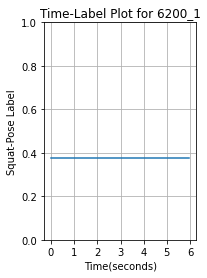

In [81]:
# Please use this section to test the model using your own test data sets keypoints generated from video image frames
# load json and create model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import sequence
import os
import numpy as np
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.models import model_from_json
import os
import tensorflow as tf
import json
import pandas as pd
import matplotlib.pyplot as plt

json_file = open('/content/trained_data_squats_keypoints.json', 'r')
loaded_model_json=json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/trained_data_squats_keypoints.h5")
print("The model weights have been loaded")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
loaded_model.summary()
#Loading Keypoints from Test Data Set 

#Defining a function to read json files i.e. keypoints files
def read_josn(filepath):
  with open(filepath,'r')as f:
    data=json.load(f)
  return(data)

#Loading Test Data Set Keypoints
testdata_keypoints=[]
for file in os.listdir('/content/keypoints'):
    full_path='/content/keypoints/'+ str(file)
    aa=read_josn(full_path)
    df=pd.DataFrame(aa)
    df=df['people'][0]['pose_keypoints_2d']
    testdata_keypoints.append(df)
testdata_keypoints=np.array(testdata_keypoints)
testdata_keypoints=testdata_keypoints.reshape(len(testdata_keypoints),1,75)
timestep=1
test_data = sequence.pad_sequences(testdata_keypoints, maxlen=timestep) 

#Using the pretrained model to make predictions of test data keypoints
temp=loaded_model.predict(test_data)
temp1=loaded_model.predict_classes(test_data)
yhat_probs = temp[:, 0]
yhat_probs=yhat_probs[:,0]
b=np.array(yhat_probs)
yhat_classes = temp1[:, 0]

fps=199/6
disp_time=1/fps
time=[]



#Plotting the time-label grapgh
for i in range(len(b)):
  step=disp_time*i
  time.append(step)
plt.subplot(121)
plt.plot(time,b)
plt.xlabel("Time(seconds)")
plt.xticks(np.arange(min(time),max(time)+1,1.0))
plt.ylabel("Squat-Pose Label")
plt.ylim(top=1)
plt.ylim(bottom=0)
plt.title("Time-Label Plot for 6200_1")
plt.grid(True)
plt.savefig('plot_6200_1.png')


groupdata=[]
for i in range(len(b)):
  #print(i)
  c=[time[i],b[i]]
  groupdata.append(c)


#Writing the output JSON file for "squats" that contain pairs of data.
#The first value of each pair represents time and the second value represents probability of the squat label
data={}
data['squats']=[]
data['squats'].append(groupdata)
f = open("data_6200_1.json","w")
f.write(str(data))
f.close()
